In [1]:
import torch
import torch.nn as nn
import torch_geometric
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
from sklearn.metrics.pairwise import polynomial_kernel, linear_kernel, sigmoid_kernel, rbf_kernel, laplacian_kernel
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt
import json
import os

c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\Carlos\anaconda3\envs\pytorch\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


 Similarity metrics

In [2]:
def binary_distance(X, Y):
    """Compute distance matrix between  rows of X, Y.

    d(x_i, y_j) = 1 if x_i == y_j, 0 in other case.

    for all rows x_i in X, y_j in Y

    """
    return (X.unsqueeze(1) == Y.unsqueeze(0)).all(-1).float()


def kernel(X, *args, **kwargs):
    """
    Compute similarity matrix of an array X using a variety of kernels
    Parameters:
        X = input data (torch.Tensor or numpy array)
    """
    # kernel parameters

    degree = kwargs.get("degree", None)
    gamma = kwargs.get("gamma", None)
    coef = kwargs.get("coef", None)
    kernel_type = kwargs.get("kernel_type", None)

    if kernel_type == "polynomial":


        # K(x,y) = (gamma * <x,y> + coef)^degree, for vectors x,y

        if (gamma != None) & (coef != None) & (degree != None):
            return torch.Tensor(polynomial_kernel(X = X, degree = degree, gamma = gamma, coef0 = coef))
        else:
            return None

    elif kernel_type == "sigmoid":

        # K(x,y) = tanh(gamma * <x,y> + coef), for vectors x,y

        if (gamma != None) & (coef != None):
            return torch.Tensor(sigmoid_kernel(X = X, gamma = gamma, coef0 = coef))
        else:
            return None

    elif kernel_type == "rbf":

        # K(x, y) = exp(-gamma ||x-y||^2)

        if (gamma != None):
            return torch.Tensor(rbf_kernel(X = X, gamma = gamma))
        else:
            return None

    elif kernel_type == "laplacian":

        # K(x, y) = exp(-gamma ||x-y||_1)

        if (gamma != None):
            return torch.Tensor(laplacian_kernel(X = X, gamma = gamma))
        else:
            return None

    else:
        return None


Model definition

In [3]:
class GCNEncoder(nn.Module):

    def __init__(self, input_size, latent_size):

        super().__init__()
        self.conv1 = GCNConv(input_size, latent_size)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.conv1(x = x, edge_index = edge_index, edge_weight = edge_weight))
        return x

class GCNDecoder(nn.Module):

    def __init__(self, latent_size, output_size):
        super().__init__()
        self.conv1 = GCNConv(latent_size, output_size)

    def forward(self, z, edge_index, edge_weight=None):
        z = F.relu(self.conv1(x = z, edge_index = edge_index, edge_weight = edge_weight))
        return z

class GAE(nn.Module):

    def __init__(self, encoder, decoder, kernel_parameters_X, optimizer, criterion, label_indep = False, kernel_parameters_Y = None):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.kernel_parameters_X = kernel_parameters_X
        self.kernel_parameters_Y = kernel_parameters_Y
        self.label_indep = label_indep
        self.optimizer = optimizer
        self.criterion = criterion

    def encode(self, x, edge_index, edge_weight=None):
        return self.encoder(x, edge_index, edge_weight)

    def decode(self, z, edge_index, edge_weight=None):
        return self.decoder(z, edge_index, edge_weight)

    def forward(self, x, edge_index, edge_weight=None):
        z = self.encode(x, edge_index, edge_weight)
        return self.decode(z, edge_index, edge_weight)

    def train_model(self, data_loader):
        self.train()

        epoch_losses = [] # log of each minibatch loss

        for X, y in tqdm(data_loader):
            self.optimizer.zero_grad()

            # graph construction
            K_X = kernel(X, **self.kernel_parameters_X)

            if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

            else:
                if self.kernel_parameters_Y == None:
                    self.kernel_parameters_Y = self.kernel_parameters_X

                K_Y = kernel(y, **self.kernel_parameters_Y)

            K_XY = K_X * K_Y # joint similarity matrix

            edge_index, edge_weight = dense_to_sparse(K_XY)

            out = self.forward(X, edge_index, edge_weight)
            loss = self.criterion(out, X) # reconstruction loss

            epoch_losses.append(loss)

            loss.backward()
            self.optimizer.step()

        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        
        return avg_loss.item()

    def test_model(self, data_loader):
        self.eval()
        epoch_losses = []

        with torch.no_grad():
            for X, y in data_loader:
                K_X = kernel(X, **self.kernel_parameters_X)

                if self.label_indep:
                    K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

                else:
                    if self.kernel_parameters_Y == None:
                        self.kernel_parameters_Y = self.kernel_parameters_X

                    K_Y = kernel(y, **self.kernel_parameters_Y)

                K_XY = K_X * K_Y

                edge_index, edge_weight = dense_to_sparse(K_XY)

                out = self.forward(X, edge_index, edge_weight)
                loss = self.criterion(out, X)
                epoch_losses.append(loss)

        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        return avg_loss.item()

Model hyperparameters

In [4]:
lr = 0.001 # learning rate
batch_size = 64
epochs = 1000
latent_size = 64 # latent space dimension

kernel_param_X = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1e-2,
    "coef": 0.5e2

}

# kernel function parameters for Y_train / Y_test. If is equal to None, we use the same parameters.

kernel_param_Y = None

"""
kernel_param_Y = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1.,
    "coef": 1.

}
"""

label_indep = True # True for categoric labels, False for numerical labels

MNIST Fashion preprocessing

In [6]:
# !git clone "https://github.com/Carlosespicur/tfm_esteban"

Cloning into 'tfm_esteban'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 29.44 MiB | 12.04 MiB/s, done.
Filtering content: 100% (2/2), 148.03 MiB | 16.42 MiB/s, done.


In [7]:


# train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
# test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")

train_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_train.csv")
test_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_test.csv")
data = pd.concat([train_data, test_data], ignore_index = True)
# print(train_data.shape, test_data.shape, data.shape)
# data.head()
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# print(train_data["label"].value_counts(normalize=True))
# print(val_data["label"].value_counts(normalize=True))
# print(test_data["label"].value_counts(normalize=True))

X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
X_train = torch.tensor(X_train, dtype = torch.float)
y_train = train_data["label"].values
y_train = torch.tensor(y_train, dtype = torch.float)
X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
X_val = torch.tensor(X_val, dtype = torch.float)
y_val = val_data["label"].values
y_val = torch.tensor(y_val, dtype = torch.float)
X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
X_test = torch.tensor(X_test, dtype = torch.float)
y_test = test_data["label"].values
y_test = torch.tensor(y_test, dtype = torch.float)

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)

input_size = X_train.size(1)

In [112]:
# # PRUEBA CON DATASET ORIGINAL 

# # train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
# # test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")

# train_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_train.csv")
# test_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_test.csv")
# # data = pd.concat([train_data, test_data], ignore_index = True)
# # print(train_data.shape, test_data.shape, data.shape)
# # data.head()
# # train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
# train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# # print(train_data["label"].value_counts(normalize=True))
# # print(val_data["label"].value_counts(normalize=True))
# # print(test_data["label"].value_counts(normalize=True))

# X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
# X_train = torch.tensor(X_train, dtype = torch.float)
# y_train = train_data["label"].values
# y_train = torch.tensor(y_train, dtype = torch.float)
# X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
# X_val = torch.tensor(X_val, dtype = torch.float)
# y_val = val_data["label"].values
# y_val = torch.tensor(y_val, dtype = torch.float)
# X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
# X_test = torch.tensor(X_test, dtype = torch.float)
# y_test = test_data["label"].values
# y_test = torch.tensor(y_test, dtype = torch.float)

# train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
# val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
# test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)

# input_size = X_train.size(1)

Model creation

In [8]:
model_encoder = GCNEncoder(input_size, latent_size)
model_decoder = GCNDecoder(latent_size, input_size)
optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y)


Model training

In [62]:
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    avg_loss_train = model.train_model(train_loader)
    avg_loss_test = model.test_model(val_loader)

    if epoch % 10 == 0:
        print(f"avg_loss_train: {avg_loss_train:.4f}, avg_loss_test: {avg_loss_test:.4f}")


Epoch: 1/1000


100%|██████████| 788/788 [00:12<00:00, 61.68it/s]


avg_loss_train: 0.0438, avg_loss_test: 0.0455
Epoch: 2/1000


100%|██████████| 788/788 [00:12<00:00, 61.99it/s]


Epoch: 3/1000


100%|██████████| 788/788 [00:12<00:00, 61.46it/s]


Epoch: 4/1000


100%|██████████| 788/788 [00:12<00:00, 61.68it/s]


Epoch: 5/1000


100%|██████████| 788/788 [00:12<00:00, 61.31it/s]


Epoch: 6/1000


100%|██████████| 788/788 [00:12<00:00, 61.43it/s]


Epoch: 7/1000


100%|██████████| 788/788 [00:12<00:00, 61.18it/s]


Epoch: 8/1000


100%|██████████| 788/788 [00:12<00:00, 61.54it/s]


Epoch: 9/1000


100%|██████████| 788/788 [00:12<00:00, 61.88it/s]


Epoch: 10/1000


100%|██████████| 788/788 [00:12<00:00, 60.86it/s]


Epoch: 11/1000


100%|██████████| 788/788 [00:12<00:00, 61.48it/s]


avg_loss_train: 0.0440, avg_loss_test: 0.0440
Epoch: 12/1000


100%|██████████| 788/788 [00:12<00:00, 61.54it/s]


Epoch: 13/1000


100%|██████████| 788/788 [00:12<00:00, 61.72it/s]


Epoch: 14/1000


100%|██████████| 788/788 [00:12<00:00, 61.39it/s]


Epoch: 15/1000


100%|██████████| 788/788 [00:12<00:00, 61.20it/s]


Epoch: 16/1000


100%|██████████| 788/788 [00:12<00:00, 61.58it/s]


Epoch: 17/1000


100%|██████████| 788/788 [00:12<00:00, 61.28it/s]


Epoch: 18/1000


100%|██████████| 788/788 [00:12<00:00, 61.62it/s]


Epoch: 19/1000


100%|██████████| 788/788 [00:13<00:00, 60.55it/s]


Epoch: 20/1000


100%|██████████| 788/788 [00:12<00:00, 61.84it/s]


Epoch: 21/1000


100%|██████████| 788/788 [00:12<00:00, 61.46it/s]


avg_loss_train: 0.0438, avg_loss_test: 0.0437
Epoch: 22/1000


100%|██████████| 788/788 [00:12<00:00, 61.88it/s]


Epoch: 23/1000


100%|██████████| 788/788 [00:12<00:00, 62.06it/s]


Epoch: 24/1000


100%|██████████| 788/788 [00:12<00:00, 61.79it/s]


Epoch: 25/1000


100%|██████████| 788/788 [00:12<00:00, 61.44it/s]


Epoch: 26/1000


100%|██████████| 788/788 [00:12<00:00, 61.72it/s]


Epoch: 27/1000


100%|██████████| 788/788 [00:13<00:00, 59.39it/s]


Epoch: 28/1000


100%|██████████| 788/788 [00:13<00:00, 60.04it/s]


Epoch: 29/1000


100%|██████████| 788/788 [00:14<00:00, 53.86it/s]


Epoch: 30/1000


100%|██████████| 788/788 [00:16<00:00, 48.07it/s]


Epoch: 31/1000


100%|██████████| 788/788 [00:14<00:00, 54.92it/s]


avg_loss_train: 0.0437, avg_loss_test: 0.0438
Epoch: 32/1000


100%|██████████| 788/788 [00:15<00:00, 52.45it/s]


Epoch: 33/1000


100%|██████████| 788/788 [00:15<00:00, 51.44it/s]


Epoch: 34/1000


100%|██████████| 788/788 [00:14<00:00, 53.99it/s]


Epoch: 35/1000


100%|██████████| 788/788 [00:14<00:00, 54.16it/s]


Epoch: 36/1000


100%|██████████| 788/788 [00:14<00:00, 53.12it/s]


Epoch: 37/1000


100%|██████████| 788/788 [00:14<00:00, 52.57it/s]


Epoch: 38/1000


100%|██████████| 788/788 [00:14<00:00, 53.82it/s]


Epoch: 39/1000


100%|██████████| 788/788 [00:14<00:00, 54.88it/s]


Epoch: 40/1000


100%|██████████| 788/788 [00:14<00:00, 55.00it/s]


Epoch: 41/1000


100%|██████████| 788/788 [00:14<00:00, 55.52it/s]


avg_loss_train: 0.0435, avg_loss_test: 0.0437
Epoch: 42/1000


100%|██████████| 788/788 [00:14<00:00, 53.34it/s]


Epoch: 43/1000


100%|██████████| 788/788 [00:14<00:00, 54.82it/s]


Epoch: 44/1000


100%|██████████| 788/788 [00:14<00:00, 55.02it/s]


Epoch: 45/1000


100%|██████████| 788/788 [00:14<00:00, 55.01it/s]


Epoch: 46/1000


100%|██████████| 788/788 [00:14<00:00, 53.27it/s]


Epoch: 47/1000


100%|██████████| 788/788 [00:14<00:00, 55.53it/s]


Epoch: 48/1000


100%|██████████| 788/788 [00:14<00:00, 54.45it/s]


Epoch: 49/1000


100%|██████████| 788/788 [00:14<00:00, 55.97it/s]


Epoch: 50/1000


100%|██████████| 788/788 [00:14<00:00, 56.11it/s]


Epoch: 51/1000


100%|██████████| 788/788 [00:15<00:00, 50.04it/s]


avg_loss_train: 0.0439, avg_loss_test: 0.0439
Epoch: 52/1000


100%|██████████| 788/788 [00:14<00:00, 53.98it/s]


Epoch: 53/1000


100%|██████████| 788/788 [00:15<00:00, 52.40it/s]


Epoch: 54/1000


100%|██████████| 788/788 [00:14<00:00, 55.04it/s]


Epoch: 55/1000


100%|██████████| 788/788 [00:14<00:00, 56.15it/s]


Epoch: 56/1000


100%|██████████| 788/788 [00:13<00:00, 56.42it/s]


Epoch: 57/1000


100%|██████████| 788/788 [00:13<00:00, 56.57it/s]


Epoch: 58/1000


100%|██████████| 788/788 [00:13<00:00, 57.06it/s]


Epoch: 59/1000


100%|██████████| 788/788 [00:13<00:00, 56.47it/s]


Epoch: 60/1000


100%|██████████| 788/788 [00:13<00:00, 57.20it/s]


Epoch: 61/1000


100%|██████████| 788/788 [00:13<00:00, 57.39it/s]


avg_loss_train: 0.0435, avg_loss_test: 0.0435
Epoch: 62/1000


100%|██████████| 788/788 [00:13<00:00, 57.25it/s]


Epoch: 63/1000


100%|██████████| 788/788 [00:14<00:00, 56.08it/s]


Epoch: 64/1000


100%|██████████| 788/788 [00:14<00:00, 56.08it/s]


Epoch: 65/1000


100%|██████████| 788/788 [00:13<00:00, 56.99it/s]


Epoch: 66/1000


100%|██████████| 788/788 [00:13<00:00, 56.72it/s]


Epoch: 67/1000


100%|██████████| 788/788 [00:13<00:00, 56.48it/s]


Epoch: 68/1000


100%|██████████| 788/788 [00:14<00:00, 55.52it/s]


Epoch: 69/1000


100%|██████████| 788/788 [00:14<00:00, 55.25it/s]


Epoch: 70/1000


100%|██████████| 788/788 [00:13<00:00, 56.99it/s]


Epoch: 71/1000


100%|██████████| 788/788 [00:13<00:00, 56.43it/s]


avg_loss_train: 0.0440, avg_loss_test: 0.0440
Epoch: 72/1000


100%|██████████| 788/788 [00:13<00:00, 57.01it/s]


Epoch: 73/1000


100%|██████████| 788/788 [00:13<00:00, 56.42it/s]


Epoch: 74/1000


100%|██████████| 788/788 [00:14<00:00, 55.58it/s]


Epoch: 75/1000


100%|██████████| 788/788 [00:14<00:00, 55.44it/s]


Epoch: 76/1000


100%|██████████| 788/788 [00:14<00:00, 54.95it/s]


Epoch: 77/1000


100%|██████████| 788/788 [00:14<00:00, 55.61it/s]


Epoch: 78/1000


100%|██████████| 788/788 [00:13<00:00, 57.05it/s]


Epoch: 79/1000


100%|██████████| 788/788 [00:13<00:00, 57.40it/s]


Epoch: 80/1000


100%|██████████| 788/788 [00:13<00:00, 57.12it/s]


Epoch: 81/1000


100%|██████████| 788/788 [00:13<00:00, 56.36it/s]


avg_loss_train: 0.0433, avg_loss_test: 0.0435
Epoch: 82/1000


100%|██████████| 788/788 [00:14<00:00, 54.49it/s]


Epoch: 83/1000


100%|██████████| 788/788 [00:14<00:00, 56.23it/s]


Epoch: 84/1000


100%|██████████| 788/788 [00:14<00:00, 55.73it/s]


Epoch: 85/1000


100%|██████████| 788/788 [00:14<00:00, 54.60it/s]


Epoch: 86/1000


100%|██████████| 788/788 [00:13<00:00, 56.56it/s]


Epoch: 87/1000


100%|██████████| 788/788 [00:13<00:00, 56.45it/s]


Epoch: 88/1000


100%|██████████| 788/788 [00:13<00:00, 57.16it/s]


Epoch: 89/1000


100%|██████████| 788/788 [00:13<00:00, 56.58it/s]


Epoch: 90/1000


100%|██████████| 788/788 [00:13<00:00, 56.43it/s]


Epoch: 91/1000


100%|██████████| 788/788 [00:14<00:00, 56.14it/s]


avg_loss_train: 0.0434, avg_loss_test: 0.0435
Epoch: 92/1000


100%|██████████| 788/788 [00:13<00:00, 57.41it/s]


Epoch: 93/1000


100%|██████████| 788/788 [00:13<00:00, 57.68it/s]


Epoch: 94/1000


100%|██████████| 788/788 [00:13<00:00, 57.40it/s]


Epoch: 95/1000


100%|██████████| 788/788 [00:13<00:00, 57.13it/s]


Epoch: 96/1000


100%|██████████| 788/788 [00:14<00:00, 54.94it/s]


Epoch: 97/1000


100%|██████████| 788/788 [00:14<00:00, 55.95it/s]


Epoch: 98/1000


100%|██████████| 788/788 [00:14<00:00, 56.23it/s]


Epoch: 99/1000


100%|██████████| 788/788 [00:13<00:00, 57.14it/s]


Epoch: 100/1000


100%|██████████| 788/788 [00:14<00:00, 55.65it/s]


Epoch: 101/1000


100%|██████████| 788/788 [00:14<00:00, 55.33it/s]


avg_loss_train: 0.0435, avg_loss_test: 0.0454
Epoch: 102/1000


100%|██████████| 788/788 [00:13<00:00, 57.01it/s]


Epoch: 103/1000


100%|██████████| 788/788 [00:14<00:00, 55.46it/s]


Epoch: 104/1000


100%|██████████| 788/788 [00:14<00:00, 55.74it/s]


Epoch: 105/1000


100%|██████████| 788/788 [00:13<00:00, 56.87it/s]


Epoch: 106/1000


100%|██████████| 788/788 [00:13<00:00, 56.60it/s]


Epoch: 107/1000


100%|██████████| 788/788 [00:14<00:00, 55.21it/s]


Epoch: 108/1000


100%|██████████| 788/788 [00:14<00:00, 56.25it/s]


Epoch: 109/1000


100%|██████████| 788/788 [00:14<00:00, 56.06it/s]


Epoch: 110/1000


100%|██████████| 788/788 [00:14<00:00, 55.15it/s]


Epoch: 111/1000


100%|██████████| 788/788 [00:14<00:00, 56.25it/s]


avg_loss_train: 0.0434, avg_loss_test: 0.0433
Epoch: 112/1000


100%|██████████| 788/788 [00:14<00:00, 55.99it/s]


Epoch: 113/1000


100%|██████████| 788/788 [00:14<00:00, 55.70it/s]


Epoch: 114/1000


100%|██████████| 788/788 [00:14<00:00, 56.22it/s]


Epoch: 115/1000


100%|██████████| 788/788 [00:13<00:00, 56.57it/s]


Epoch: 116/1000


100%|██████████| 788/788 [00:13<00:00, 56.65it/s]


Epoch: 117/1000


100%|██████████| 788/788 [00:13<00:00, 56.40it/s]


Epoch: 118/1000


100%|██████████| 788/788 [00:13<00:00, 56.36it/s]


Epoch: 119/1000


100%|██████████| 788/788 [00:13<00:00, 57.08it/s]


Epoch: 120/1000


100%|██████████| 788/788 [00:13<00:00, 56.87it/s]


Epoch: 121/1000


100%|██████████| 788/788 [00:13<00:00, 56.49it/s]


avg_loss_train: 0.0435, avg_loss_test: 0.0435
Epoch: 122/1000


100%|██████████| 788/788 [00:13<00:00, 56.65it/s]


Epoch: 123/1000


100%|██████████| 788/788 [00:14<00:00, 56.14it/s]


Epoch: 124/1000


100%|██████████| 788/788 [00:14<00:00, 55.24it/s]


Epoch: 125/1000


100%|██████████| 788/788 [00:14<00:00, 55.29it/s]


Epoch: 126/1000


100%|██████████| 788/788 [00:14<00:00, 55.87it/s]


Epoch: 127/1000


100%|██████████| 788/788 [00:14<00:00, 56.17it/s]


Epoch: 128/1000


100%|██████████| 788/788 [00:14<00:00, 55.36it/s]


Epoch: 129/1000


100%|██████████| 788/788 [00:14<00:00, 56.27it/s]


Epoch: 130/1000


100%|██████████| 788/788 [00:13<00:00, 56.52it/s]


Epoch: 131/1000


100%|██████████| 788/788 [00:14<00:00, 55.91it/s]


avg_loss_train: 0.0434, avg_loss_test: 0.0432
Epoch: 132/1000


100%|██████████| 788/788 [00:14<00:00, 54.02it/s]


Epoch: 133/1000


100%|██████████| 788/788 [00:14<00:00, 55.67it/s]


Epoch: 134/1000


100%|██████████| 788/788 [00:13<00:00, 56.59it/s]


Epoch: 135/1000


100%|██████████| 788/788 [00:13<00:00, 56.62it/s]


Epoch: 136/1000


100%|██████████| 788/788 [00:13<00:00, 57.05it/s]


Epoch: 137/1000


100%|██████████| 788/788 [00:13<00:00, 57.10it/s]


Epoch: 138/1000


100%|██████████| 788/788 [00:13<00:00, 56.29it/s]


Epoch: 139/1000


100%|██████████| 788/788 [00:14<00:00, 55.92it/s]


Epoch: 140/1000


100%|██████████| 788/788 [00:14<00:00, 55.65it/s]


Epoch: 141/1000


100%|██████████| 788/788 [00:14<00:00, 56.06it/s]


avg_loss_train: 0.0437, avg_loss_test: 0.0433
Epoch: 142/1000


100%|██████████| 788/788 [00:13<00:00, 56.41it/s]


Epoch: 143/1000


 57%|█████▋    | 447/788 [00:07<00:06, 56.45it/s]


KeyboardInterrupt: 

Model testing

In [113]:
model.test_model(test_loader)

0.04323119297623634

In [114]:
for X, y in test_loader:
    K_X = kernel(X, **kernel_param_X)
    K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))
    K_XY = K_X * K_Y

    edge_index, edge_weight = dense_to_sparse(K_XY)
    out = model(X, edge_index, edge_weight)

    break

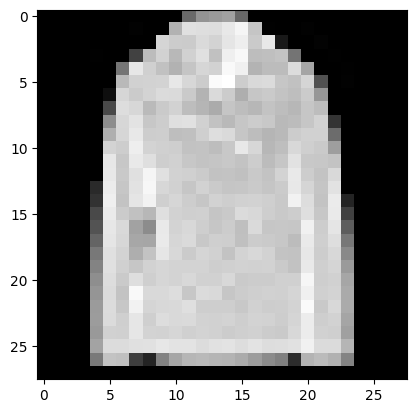

In [118]:
data_number = 60
prueba = X[data_number].detach().numpy().reshape(28, 28)
plt.imshow(prueba, cmap = "gray")

In [119]:
y[data_number]

tensor(4.)

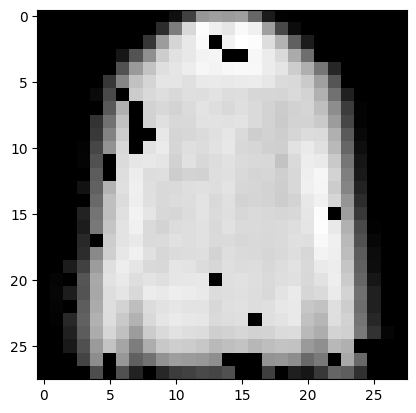

In [120]:
prueba_out = out[data_number].detach().numpy().reshape(28, 28)
plt.imshow(prueba_out, cmap = "gray")

Training a MLP for classification with embeddings of the previous GNN model

In [121]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_hidden_layers, output_size, lr, criterion, use_embeddings = True):
    super().__init__()
    
    self.criterion = criterion
    activation = nn.ReLU()
    self.MLP_layers = nn.ModuleList()
    layer = nn.Linear(input_size, hidden_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(activation)
    self.use_embeddings = use_embeddings

    for _ in range(num_hidden_layers - 1):

      layer = nn.Linear(hidden_size, hidden_size)
      nn.init.xavier_uniform(layer.weight)
      layer.bias.data.fill_(0.01)
      self.MLP_layers.append(layer)
      self.MLP_layers.append(activation)

    layer = nn.Linear(hidden_size, output_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(nn.Sigmoid())

    self.optimizer = Adam(self.parameters(), lr)

  def forward(self, x):
    for layer in self.MLP_layers:
      x = layer(x)

    return x
  
  def train_model(self, train_loader):

    self.train()

    epoch_losses = []
    epoch_accuracies = []

    for X, y in tqdm(train_loader):

      self.optimizer.zero_grad()
      if self.use_embeddings:
        with torch.no_grad():
          K_X = kernel(X, **kernel_param_X)
          K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))
          K_XY = K_X * K_Y

          edge_index, edge_weight = dense_to_sparse(K_XY)
          Z = model.encode(X, edge_index, edge_weight)
        out = self.forward(Z)
      else:
        out = self.forward(X)
      
      loss = self.criterion(out, y.long())
      preds = torch.argmax(out, dim = 1)
      accuracy = torch.mean((preds == y.long()).float())
      epoch_losses.append(loss)
      epoch_accuracies.append(accuracy)
      loss.backward()
      self.optimizer.step()

    avg_loss = torch.mean(torch.Tensor(epoch_losses))
    avg_accuracy = torch.mean(torch.Tensor(epoch_accuracies))

    return avg_loss.item(), avg_accuracy.item()
  
  def test_model(self, data_loader):

    self.eval()

    test_losses = []
    test_accuracies = []

    for X, y in tqdm(data_loader):
        if self.use_embeddings:
          with torch.no_grad():
            K_X = kernel(X, **kernel_param_X)
            K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))
            K_XY = K_X * K_Y

            edge_index, edge_weight = dense_to_sparse(K_XY)
            Z = model.encode(X, edge_index, edge_weight)
          out = self.forward(Z)
        else:
          out = self.forward(X)
        
        loss = self.criterion(out, y.long())
        preds = torch.argmax(out, dim = 1)
        accuracy = torch.mean((preds == y.long()).float())
        test_losses.append(loss)
        test_accuracies.append(accuracy)
    avg_loss = torch.mean(torch.Tensor(test_losses))
    avg_accuracy = torch.mean(torch.Tensor(test_accuracies))

    return avg_loss.item(), avg_accuracy.item()


In [122]:
lr_classif = 0.001
loss = nn.CrossEntropyLoss()
classif = MLP(latent_size, 16, 3, 10, lr_classif, loss, use_embeddings = True)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12656\474158631.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_12656\474158631.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_12656\474158631.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [123]:
classif.parameters

<bound method Module.parameters of MLP(
  (criterion): CrossEntropyLoss()
  (MLP_layers): ModuleList(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=10, bias=True)
    (7): Sigmoid()
  )
)>

In [124]:
epochs_classif = 200

In [125]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 94/94 [00:00<00:00, 188.00it/s]


avg_loss_train: 1.8129, avg_accuracy_train: 0.4967
avg_loss_val: 1.6204, avg_accuracy_val: 0.6406
epoch: 2/200


100%|██████████| 94/94 [00:00<00:00, 193.90it/s]


avg_loss_train: 1.5882, avg_accuracy_train: 0.6753
avg_loss_val: 1.5639, avg_accuracy_val: 0.6852
epoch: 3/200


100%|██████████| 94/94 [00:00<00:00, 180.78it/s]


avg_loss_train: 1.5564, avg_accuracy_train: 0.7342
avg_loss_val: 1.5464, avg_accuracy_val: 0.7456
epoch: 4/200


100%|██████████| 94/94 [00:00<00:00, 185.78it/s]


avg_loss_train: 1.5419, avg_accuracy_train: 0.7850
avg_loss_val: 1.5327, avg_accuracy_val: 0.7844
epoch: 5/200


100%|██████████| 94/94 [00:00<00:00, 194.44it/s]


avg_loss_train: 1.5243, avg_accuracy_train: 0.8051
avg_loss_val: 1.5156, avg_accuracy_val: 0.8107
epoch: 6/200


100%|██████████| 94/94 [00:00<00:00, 193.44it/s]


avg_loss_train: 1.5139, avg_accuracy_train: 0.8060
avg_loss_val: 1.5082, avg_accuracy_val: 0.8187
epoch: 7/200


100%|██████████| 94/94 [00:00<00:00, 195.25it/s]


avg_loss_train: 1.5099, avg_accuracy_train: 0.8145
avg_loss_val: 1.5073, avg_accuracy_val: 0.8306
epoch: 8/200


100%|██████████| 94/94 [00:00<00:00, 191.46it/s]


avg_loss_train: 1.5080, avg_accuracy_train: 0.8379
avg_loss_val: 1.5058, avg_accuracy_val: 0.8490
epoch: 9/200


100%|██████████| 94/94 [00:00<00:00, 173.92it/s]


avg_loss_train: 1.5100, avg_accuracy_train: 0.8345
avg_loss_val: 1.5101, avg_accuracy_val: 0.8383
epoch: 10/200


100%|██████████| 94/94 [00:00<00:00, 197.71it/s]


avg_loss_train: 1.5066, avg_accuracy_train: 0.8548
avg_loss_val: 1.5057, avg_accuracy_val: 0.8551
epoch: 11/200


100%|██████████| 94/94 [00:00<00:00, 195.66it/s]


avg_loss_train: 1.5065, avg_accuracy_train: 0.8551
avg_loss_val: 1.5045, avg_accuracy_val: 0.8399
epoch: 12/200


100%|██████████| 94/94 [00:00<00:00, 171.69it/s]


avg_loss_train: 1.5052, avg_accuracy_train: 0.8750
avg_loss_val: 1.5087, avg_accuracy_val: 0.8324
epoch: 13/200


100%|██████████| 94/94 [00:00<00:00, 189.59it/s]


avg_loss_train: 1.5051, avg_accuracy_train: 0.8825
avg_loss_val: 1.5035, avg_accuracy_val: 0.8838
epoch: 14/200


100%|██████████| 94/94 [00:00<00:00, 186.04it/s]


avg_loss_train: 1.5040, avg_accuracy_train: 0.9010
avg_loss_val: 1.5013, avg_accuracy_val: 0.8984
epoch: 15/200


100%|██████████| 94/94 [00:00<00:00, 173.64it/s]


avg_loss_train: 1.5023, avg_accuracy_train: 0.9116
avg_loss_val: 1.5045, avg_accuracy_val: 0.9331
epoch: 16/200


100%|██████████| 94/94 [00:00<00:00, 183.99it/s]


avg_loss_train: 1.4980, avg_accuracy_train: 0.9415
avg_loss_val: 1.4907, avg_accuracy_val: 0.9466
epoch: 17/200


100%|██████████| 94/94 [00:00<00:00, 176.36it/s]


avg_loss_train: 1.4929, avg_accuracy_train: 0.9185
avg_loss_val: 1.4887, avg_accuracy_val: 0.9173
epoch: 18/200


100%|██████████| 94/94 [00:00<00:00, 193.44it/s]


avg_loss_train: 1.4910, avg_accuracy_train: 0.9217
avg_loss_val: 1.4872, avg_accuracy_val: 0.9335
epoch: 19/200


100%|██████████| 94/94 [00:00<00:00, 146.51it/s]


avg_loss_train: 1.4911, avg_accuracy_train: 0.9196
avg_loss_val: 1.4913, avg_accuracy_val: 0.9276
epoch: 20/200


100%|██████████| 94/94 [00:00<00:00, 194.44it/s]


avg_loss_train: 1.4894, avg_accuracy_train: 0.9321
avg_loss_val: 1.4858, avg_accuracy_val: 0.9532
epoch: 21/200


100%|██████████| 94/94 [00:00<00:00, 190.17it/s]


avg_loss_train: 1.4883, avg_accuracy_train: 0.9432
avg_loss_val: 1.4840, avg_accuracy_val: 0.9758
epoch: 22/200


100%|██████████| 94/94 [00:00<00:00, 185.24it/s]


avg_loss_train: 1.4895, avg_accuracy_train: 0.9387
avg_loss_val: 1.4868, avg_accuracy_val: 0.9229
epoch: 23/200


100%|██████████| 94/94 [00:00<00:00, 192.84it/s]


avg_loss_train: 1.4868, avg_accuracy_train: 0.9494
avg_loss_val: 1.4886, avg_accuracy_val: 0.9644
epoch: 24/200


100%|██████████| 94/94 [00:00<00:00, 176.19it/s]


avg_loss_train: 1.4889, avg_accuracy_train: 0.9576
avg_loss_val: 1.4845, avg_accuracy_val: 0.9530
epoch: 25/200


100%|██████████| 94/94 [00:00<00:00, 194.43it/s]


avg_loss_train: 1.4874, avg_accuracy_train: 0.9552
avg_loss_val: 1.4833, avg_accuracy_val: 0.9449
epoch: 26/200


100%|██████████| 94/94 [00:00<00:00, 175.78it/s]


avg_loss_train: 1.4873, avg_accuracy_train: 0.9693
avg_loss_val: 1.4721, avg_accuracy_val: 0.9900
epoch: 27/200


100%|██████████| 94/94 [00:00<00:00, 190.50it/s]


avg_loss_train: 1.4745, avg_accuracy_train: 0.9832
avg_loss_val: 1.4709, avg_accuracy_val: 0.9884
epoch: 28/200


100%|██████████| 94/94 [00:00<00:00, 196.47it/s]


avg_loss_train: 1.4733, avg_accuracy_train: 0.9853
avg_loss_val: 1.4717, avg_accuracy_val: 0.9857
epoch: 29/200


100%|██████████| 94/94 [00:00<00:00, 184.15it/s]


avg_loss_train: 1.4727, avg_accuracy_train: 0.9855
avg_loss_val: 1.4787, avg_accuracy_val: 0.9754
epoch: 30/200


100%|██████████| 94/94 [00:00<00:00, 190.88it/s]


avg_loss_train: 1.4721, avg_accuracy_train: 0.9869
avg_loss_val: 1.4725, avg_accuracy_val: 0.9870
epoch: 31/200


100%|██████████| 94/94 [00:00<00:00, 192.45it/s]


avg_loss_train: 1.4716, avg_accuracy_train: 0.9871
avg_loss_val: 1.4750, avg_accuracy_val: 0.9820
epoch: 32/200


100%|██████████| 94/94 [00:00<00:00, 174.89it/s]


avg_loss_train: 1.4735, avg_accuracy_train: 0.9841
avg_loss_val: 1.4734, avg_accuracy_val: 0.9865
epoch: 33/200


100%|██████████| 94/94 [00:00<00:00, 146.67it/s]


avg_loss_train: 1.4733, avg_accuracy_train: 0.9841
avg_loss_val: 1.4691, avg_accuracy_val: 0.9917
epoch: 34/200


100%|██████████| 94/94 [00:00<00:00, 195.45it/s]


avg_loss_train: 1.4725, avg_accuracy_train: 0.9851
avg_loss_val: 1.4778, avg_accuracy_val: 0.9787
epoch: 35/200


100%|██████████| 94/94 [00:00<00:00, 194.80it/s]


avg_loss_train: 1.4715, avg_accuracy_train: 0.9879
avg_loss_val: 1.4719, avg_accuracy_val: 0.9852
epoch: 36/200


100%|██████████| 94/94 [00:00<00:00, 181.65it/s]


avg_loss_train: 1.4714, avg_accuracy_train: 0.9859
avg_loss_val: 1.4675, avg_accuracy_val: 0.9910
epoch: 37/200


100%|██████████| 94/94 [00:00<00:00, 172.96it/s]


avg_loss_train: 1.4729, avg_accuracy_train: 0.9854
avg_loss_val: 1.4712, avg_accuracy_val: 0.9874
epoch: 38/200


100%|██████████| 94/94 [00:00<00:00, 188.85it/s]


avg_loss_train: 1.4717, avg_accuracy_train: 0.9850
avg_loss_val: 1.4687, avg_accuracy_val: 0.9897
epoch: 39/200


100%|██████████| 94/94 [00:00<00:00, 186.52it/s]


avg_loss_train: 1.4719, avg_accuracy_train: 0.9856
avg_loss_val: 1.4729, avg_accuracy_val: 0.9815
epoch: 40/200


100%|██████████| 94/94 [00:00<00:00, 181.65it/s]


avg_loss_train: 1.4706, avg_accuracy_train: 0.9883
avg_loss_val: 1.4731, avg_accuracy_val: 0.9872
epoch: 41/200


100%|██████████| 94/94 [00:00<00:00, 191.66it/s]


avg_loss_train: 1.4719, avg_accuracy_train: 0.9873
avg_loss_val: 1.4738, avg_accuracy_val: 0.9833
epoch: 42/200


100%|██████████| 94/94 [00:00<00:00, 182.36it/s]


avg_loss_train: 1.4717, avg_accuracy_train: 0.9866
avg_loss_val: 1.4700, avg_accuracy_val: 0.9855
epoch: 43/200


100%|██████████| 94/94 [00:00<00:00, 184.51it/s]


avg_loss_train: 1.4706, avg_accuracy_train: 0.9878
avg_loss_val: 1.4698, avg_accuracy_val: 0.9900
epoch: 44/200


100%|██████████| 94/94 [00:00<00:00, 187.69it/s]


avg_loss_train: 1.4716, avg_accuracy_train: 0.9862
avg_loss_val: 1.4688, avg_accuracy_val: 0.9900
epoch: 45/200


 40%|████      | 338/844 [00:02<00:03, 131.76it/s]


KeyboardInterrupt: 

In [126]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

100%|██████████| 157/157 [00:00<00:00, 213.55it/s]

avg_loss_test: 1.4693, avg_accuracy_test: 0.9866


Comparing with MLP trained on input images

In [76]:
classif_inputs = MLP(input_size, 16, 3, 10, lr_classif, loss, use_embeddings = False)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12656\474158631.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_12656\474158631.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_12656\474158631.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [77]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif_inputs.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif_inputs.test_model(val_loader)
    
    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 88/88 [00:00<00:00, 646.47it/s]


avg_loss_train: 1.7687, avg_accuracy_train: 0.3556
avg_loss_val: 1.6732, avg_accuracy_val: 0.4331
epoch: 2/200


100%|██████████| 88/88 [00:00<00:00, 651.26it/s]


avg_loss_train: 1.6479, avg_accuracy_train: 0.4720
avg_loss_val: 1.6380, avg_accuracy_val: 0.4890
epoch: 3/200


100%|██████████| 88/88 [00:00<00:00, 563.59it/s]


avg_loss_train: 1.6341, avg_accuracy_train: 0.4882
avg_loss_val: 1.6306, avg_accuracy_val: 0.4979
epoch: 4/200


100%|██████████| 88/88 [00:00<00:00, 671.14it/s]


avg_loss_train: 1.6274, avg_accuracy_train: 0.4999
avg_loss_val: 1.6250, avg_accuracy_val: 0.5060
epoch: 5/200


100%|██████████| 88/88 [00:00<00:00, 587.55it/s]


avg_loss_train: 1.6218, avg_accuracy_train: 0.5050
avg_loss_val: 1.6187, avg_accuracy_val: 0.5144
epoch: 6/200


100%|██████████| 88/88 [00:00<00:00, 563.58it/s]


avg_loss_train: 1.6176, avg_accuracy_train: 0.5109
avg_loss_val: 1.6167, avg_accuracy_val: 0.5197
epoch: 7/200


100%|██████████| 88/88 [00:00<00:00, 661.05it/s]


avg_loss_train: 1.6123, avg_accuracy_train: 0.5158
avg_loss_val: 1.6103, avg_accuracy_val: 0.5165
epoch: 8/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.6078, avg_accuracy_train: 0.5200
avg_loss_val: 1.6175, avg_accuracy_val: 0.5096
epoch: 9/200


100%|██████████| 88/88 [00:00<00:00, 598.10it/s]


avg_loss_train: 1.6056, avg_accuracy_train: 0.5303
avg_loss_val: 1.6117, avg_accuracy_val: 0.5201
epoch: 10/200


100%|██████████| 88/88 [00:00<00:00, 666.06it/s]


avg_loss_train: 1.6037, avg_accuracy_train: 0.5404
avg_loss_val: 1.6081, avg_accuracy_val: 0.5327
epoch: 11/200


100%|██████████| 88/88 [00:00<00:00, 656.11it/s]


avg_loss_train: 1.6019, avg_accuracy_train: 0.5638
avg_loss_val: 1.6070, avg_accuracy_val: 0.5863
epoch: 12/200


100%|██████████| 88/88 [00:00<00:00, 590.07it/s]


avg_loss_train: 1.5997, avg_accuracy_train: 0.5800
avg_loss_val: 1.6020, avg_accuracy_val: 0.5774
epoch: 13/200


100%|██████████| 88/88 [00:00<00:00, 598.10it/s]


avg_loss_train: 1.5963, avg_accuracy_train: 0.6145
avg_loss_val: 1.6001, avg_accuracy_val: 0.6211
epoch: 14/200


100%|██████████| 88/88 [00:00<00:00, 635.11it/s]


avg_loss_train: 1.5936, avg_accuracy_train: 0.6244
avg_loss_val: 1.5971, avg_accuracy_val: 0.6483
epoch: 15/200


100%|██████████| 88/88 [00:00<00:00, 614.82it/s]


avg_loss_train: 1.5905, avg_accuracy_train: 0.6465
avg_loss_val: 1.5985, avg_accuracy_val: 0.6452
epoch: 16/200


100%|██████████| 88/88 [00:00<00:00, 621.81it/s]


avg_loss_train: 1.5898, avg_accuracy_train: 0.6487
avg_loss_val: 1.5926, avg_accuracy_val: 0.6625
epoch: 17/200


100%|██████████| 88/88 [00:00<00:00, 634.10it/s]


avg_loss_train: 1.5855, avg_accuracy_train: 0.6561
avg_loss_val: 1.5813, avg_accuracy_val: 0.6697
epoch: 18/200


100%|██████████| 88/88 [00:00<00:00, 641.74it/s]


avg_loss_train: 1.5757, avg_accuracy_train: 0.6693
avg_loss_val: 1.5811, avg_accuracy_val: 0.6752
epoch: 19/200


100%|██████████| 88/88 [00:00<00:00, 651.26it/s]


avg_loss_train: 1.5747, avg_accuracy_train: 0.6693
avg_loss_val: 1.5790, avg_accuracy_val: 0.6731
epoch: 20/200


100%|██████████| 88/88 [00:00<00:00, 653.29it/s]


avg_loss_train: 1.5734, avg_accuracy_train: 0.6721
avg_loss_val: 1.5784, avg_accuracy_val: 0.6765
epoch: 21/200


100%|██████████| 88/88 [00:00<00:00, 656.12it/s]


avg_loss_train: 1.5724, avg_accuracy_train: 0.6727
avg_loss_val: 1.5794, avg_accuracy_val: 0.6721
epoch: 22/200


100%|██████████| 88/88 [00:00<00:00, 574.64it/s]


avg_loss_train: 1.5713, avg_accuracy_train: 0.6721
avg_loss_val: 1.5761, avg_accuracy_val: 0.6745
epoch: 23/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5713, avg_accuracy_train: 0.6744
avg_loss_val: 1.5768, avg_accuracy_val: 0.6747
epoch: 24/200


100%|██████████| 88/88 [00:00<00:00, 666.06it/s]


avg_loss_train: 1.5706, avg_accuracy_train: 0.6748
avg_loss_val: 1.5795, avg_accuracy_val: 0.6733
epoch: 25/200


100%|██████████| 88/88 [00:00<00:00, 637.11it/s]


avg_loss_train: 1.5703, avg_accuracy_train: 0.6752
avg_loss_val: 1.5780, avg_accuracy_val: 0.6751
epoch: 26/200


100%|██████████| 88/88 [00:00<00:00, 656.12it/s]


avg_loss_train: 1.5690, avg_accuracy_train: 0.6749
avg_loss_val: 1.5800, avg_accuracy_val: 0.6749
epoch: 27/200


100%|██████████| 88/88 [00:00<00:00, 639.52it/s]


avg_loss_train: 1.5690, avg_accuracy_train: 0.6756
avg_loss_val: 1.5764, avg_accuracy_val: 0.6802
epoch: 28/200


100%|██████████| 88/88 [00:00<00:00, 628.00it/s]


avg_loss_train: 1.5684, avg_accuracy_train: 0.6763
avg_loss_val: 1.5799, avg_accuracy_val: 0.6731
epoch: 29/200


100%|██████████| 88/88 [00:00<00:00, 586.40it/s]


avg_loss_train: 1.5671, avg_accuracy_train: 0.6773
avg_loss_val: 1.5774, avg_accuracy_val: 0.6754
epoch: 30/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5667, avg_accuracy_train: 0.6767
avg_loss_val: 1.5774, avg_accuracy_val: 0.6710
epoch: 31/200


100%|██████████| 88/88 [00:00<00:00, 656.12it/s]


avg_loss_train: 1.5672, avg_accuracy_train: 0.6761
avg_loss_val: 1.5758, avg_accuracy_val: 0.6756
epoch: 32/200


100%|██████████| 88/88 [00:00<00:00, 656.12it/s]


avg_loss_train: 1.5664, avg_accuracy_train: 0.6783
avg_loss_val: 1.5779, avg_accuracy_val: 0.6772
epoch: 33/200


100%|██████████| 88/88 [00:00<00:00, 574.64it/s]


avg_loss_train: 1.5654, avg_accuracy_train: 0.6774
avg_loss_val: 1.5754, avg_accuracy_val: 0.6813
epoch: 34/200


100%|██████████| 88/88 [00:00<00:00, 594.05it/s]


avg_loss_train: 1.5648, avg_accuracy_train: 0.6783
avg_loss_val: 1.5743, avg_accuracy_val: 0.6777
epoch: 35/200


100%|██████████| 88/88 [00:00<00:00, 582.26it/s]


avg_loss_train: 1.5651, avg_accuracy_train: 0.6776
avg_loss_val: 1.5771, avg_accuracy_val: 0.6772
epoch: 36/200


100%|██████████| 88/88 [00:00<00:00, 532.85it/s]


avg_loss_train: 1.5644, avg_accuracy_train: 0.6785
avg_loss_val: 1.5757, avg_accuracy_val: 0.6788
epoch: 37/200


100%|██████████| 88/88 [00:00<00:00, 542.72it/s]


avg_loss_train: 1.5649, avg_accuracy_train: 0.6779
avg_loss_val: 1.5778, avg_accuracy_val: 0.6765
epoch: 38/200


100%|██████████| 88/88 [00:00<00:00, 619.16it/s]


avg_loss_train: 1.5634, avg_accuracy_train: 0.6789
avg_loss_val: 1.5781, avg_accuracy_val: 0.6793
epoch: 39/200


100%|██████████| 88/88 [00:00<00:00, 634.16it/s]


avg_loss_train: 1.5643, avg_accuracy_train: 0.6788
avg_loss_val: 1.5742, avg_accuracy_val: 0.6825
epoch: 40/200


100%|██████████| 88/88 [00:00<00:00, 579.70it/s]


avg_loss_train: 1.5635, avg_accuracy_train: 0.6798
avg_loss_val: 1.5791, avg_accuracy_val: 0.6722
epoch: 41/200


100%|██████████| 88/88 [00:00<00:00, 619.15it/s]


avg_loss_train: 1.5632, avg_accuracy_train: 0.6796
avg_loss_val: 1.5737, avg_accuracy_val: 0.6838
epoch: 42/200


100%|██████████| 88/88 [00:00<00:00, 617.11it/s]


avg_loss_train: 1.5630, avg_accuracy_train: 0.6800
avg_loss_val: 1.5717, avg_accuracy_val: 0.6820
epoch: 43/200


100%|██████████| 88/88 [00:00<00:00, 611.00it/s]


avg_loss_train: 1.5618, avg_accuracy_train: 0.6796
avg_loss_val: 1.5759, avg_accuracy_val: 0.6834
epoch: 44/200


100%|██████████| 88/88 [00:00<00:00, 589.30it/s]


avg_loss_train: 1.5628, avg_accuracy_train: 0.6808
avg_loss_val: 1.5758, avg_accuracy_val: 0.6799
epoch: 45/200


100%|██████████| 88/88 [00:00<00:00, 552.96it/s]


avg_loss_train: 1.5628, avg_accuracy_train: 0.6803
avg_loss_val: 1.5762, avg_accuracy_val: 0.6745
epoch: 46/200


100%|██████████| 88/88 [00:00<00:00, 536.10it/s]


avg_loss_train: 1.5622, avg_accuracy_train: 0.6807
avg_loss_val: 1.5751, avg_accuracy_val: 0.6806
epoch: 47/200


100%|██████████| 88/88 [00:00<00:00, 627.49it/s]


avg_loss_train: 1.5615, avg_accuracy_train: 0.6800
avg_loss_val: 1.5984, avg_accuracy_val: 0.6610
epoch: 48/200


100%|██████████| 88/88 [00:00<00:00, 569.28it/s]


avg_loss_train: 1.5614, avg_accuracy_train: 0.6803
avg_loss_val: 1.5784, avg_accuracy_val: 0.6795
epoch: 49/200


100%|██████████| 88/88 [00:00<00:00, 666.06it/s]


avg_loss_train: 1.5626, avg_accuracy_train: 0.6796
avg_loss_val: 1.5730, avg_accuracy_val: 0.6784
epoch: 50/200


100%|██████████| 88/88 [00:00<00:00, 646.47it/s]


avg_loss_train: 1.5608, avg_accuracy_train: 0.6810
avg_loss_val: 1.5735, avg_accuracy_val: 0.6802
epoch: 51/200


100%|██████████| 88/88 [00:00<00:00, 574.68it/s]


avg_loss_train: 1.5603, avg_accuracy_train: 0.6807
avg_loss_val: 1.5763, avg_accuracy_val: 0.6770
epoch: 52/200


100%|██████████| 88/88 [00:00<00:00, 623.55it/s]


avg_loss_train: 1.5614, avg_accuracy_train: 0.6812
avg_loss_val: 1.5726, avg_accuracy_val: 0.6816
epoch: 53/200


100%|██████████| 88/88 [00:00<00:00, 656.12it/s]


avg_loss_train: 1.5597, avg_accuracy_train: 0.6822
avg_loss_val: 1.5746, avg_accuracy_val: 0.6774
epoch: 54/200


100%|██████████| 88/88 [00:00<00:00, 651.26it/s]


avg_loss_train: 1.5598, avg_accuracy_train: 0.6813
avg_loss_val: 1.5739, avg_accuracy_val: 0.6790
epoch: 55/200


100%|██████████| 88/88 [00:00<00:00, 632.55it/s]


avg_loss_train: 1.5606, avg_accuracy_train: 0.6803
avg_loss_val: 1.5723, avg_accuracy_val: 0.6816
epoch: 56/200


100%|██████████| 88/88 [00:00<00:00, 620.86it/s]


avg_loss_train: 1.5599, avg_accuracy_train: 0.6822
avg_loss_val: 1.5781, avg_accuracy_val: 0.6742
epoch: 57/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5588, avg_accuracy_train: 0.6828
avg_loss_val: 1.5722, avg_accuracy_val: 0.6808
epoch: 58/200


100%|██████████| 88/88 [00:00<00:00, 623.55it/s]


avg_loss_train: 1.5593, avg_accuracy_train: 0.6809
avg_loss_val: 1.5720, avg_accuracy_val: 0.6818
epoch: 59/200


100%|██████████| 88/88 [00:00<00:00, 577.58it/s]


avg_loss_train: 1.5590, avg_accuracy_train: 0.6824
avg_loss_val: 1.5716, avg_accuracy_val: 0.6841
epoch: 60/200


100%|██████████| 88/88 [00:00<00:00, 651.25it/s]


avg_loss_train: 1.5593, avg_accuracy_train: 0.6827
avg_loss_val: 1.5762, avg_accuracy_val: 0.6802
epoch: 61/200


100%|██████████| 88/88 [00:00<00:00, 586.13it/s]


avg_loss_train: 1.5586, avg_accuracy_train: 0.6820
avg_loss_val: 1.5746, avg_accuracy_val: 0.6811
epoch: 62/200


100%|██████████| 88/88 [00:00<00:00, 628.00it/s]


avg_loss_train: 1.5594, avg_accuracy_train: 0.6822
avg_loss_val: 1.5740, avg_accuracy_val: 0.6763
epoch: 63/200


100%|██████████| 88/88 [00:00<00:00, 637.10it/s]


avg_loss_train: 1.5598, avg_accuracy_train: 0.6815
avg_loss_val: 1.5733, avg_accuracy_val: 0.6768
epoch: 64/200


100%|██████████| 88/88 [00:00<00:00, 628.00it/s]


avg_loss_train: 1.5589, avg_accuracy_train: 0.6815
avg_loss_val: 1.5718, avg_accuracy_val: 0.6808
epoch: 65/200


100%|██████████| 88/88 [00:00<00:00, 641.76it/s]


avg_loss_train: 1.5583, avg_accuracy_train: 0.6819
avg_loss_val: 1.5882, avg_accuracy_val: 0.6689
epoch: 66/200


100%|██████████| 88/88 [00:00<00:00, 563.85it/s]


avg_loss_train: 1.5583, avg_accuracy_train: 0.6823
avg_loss_val: 1.5733, avg_accuracy_val: 0.6751
epoch: 67/200


100%|██████████| 88/88 [00:00<00:00, 487.09it/s]


avg_loss_train: 1.5584, avg_accuracy_train: 0.6834
avg_loss_val: 1.5722, avg_accuracy_val: 0.6825
epoch: 68/200


100%|██████████| 88/88 [00:00<00:00, 637.11it/s]


avg_loss_train: 1.5580, avg_accuracy_train: 0.6824
avg_loss_val: 1.5709, avg_accuracy_val: 0.6864
epoch: 69/200


100%|██████████| 88/88 [00:00<00:00, 637.07it/s]


avg_loss_train: 1.5584, avg_accuracy_train: 0.6816
avg_loss_val: 1.5724, avg_accuracy_val: 0.6827
epoch: 70/200


100%|██████████| 88/88 [00:00<00:00, 632.53it/s]


avg_loss_train: 1.5577, avg_accuracy_train: 0.6817
avg_loss_val: 1.5711, avg_accuracy_val: 0.6783
epoch: 71/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5588, avg_accuracy_train: 0.6828
avg_loss_val: 1.5712, avg_accuracy_val: 0.6852
epoch: 72/200


100%|██████████| 88/88 [00:00<00:00, 610.56it/s]


avg_loss_train: 1.5584, avg_accuracy_train: 0.6819
avg_loss_val: 1.5769, avg_accuracy_val: 0.6726
epoch: 73/200


100%|██████████| 88/88 [00:00<00:00, 583.24it/s]


avg_loss_train: 1.5578, avg_accuracy_train: 0.6826
avg_loss_val: 1.5730, avg_accuracy_val: 0.6831
epoch: 74/200


100%|██████████| 88/88 [00:00<00:00, 499.54it/s]


avg_loss_train: 1.5577, avg_accuracy_train: 0.6824
avg_loss_val: 1.5724, avg_accuracy_val: 0.6800
epoch: 75/200


100%|██████████| 88/88 [00:00<00:00, 643.81it/s]


avg_loss_train: 1.5565, avg_accuracy_train: 0.6853
avg_loss_val: 1.5766, avg_accuracy_val: 0.6699
epoch: 76/200


100%|██████████| 88/88 [00:00<00:00, 623.99it/s]


avg_loss_train: 1.5573, avg_accuracy_train: 0.6847
avg_loss_val: 1.5724, avg_accuracy_val: 0.6733
epoch: 77/200


100%|██████████| 88/88 [00:00<00:00, 646.47it/s]


avg_loss_train: 1.5570, avg_accuracy_train: 0.6872
avg_loss_val: 1.5734, avg_accuracy_val: 0.6818
epoch: 78/200


100%|██████████| 88/88 [00:00<00:00, 651.26it/s]


avg_loss_train: 1.5563, avg_accuracy_train: 0.6863
avg_loss_val: 1.5722, avg_accuracy_val: 0.6813
epoch: 79/200


100%|██████████| 88/88 [00:00<00:00, 632.52it/s]


avg_loss_train: 1.5564, avg_accuracy_train: 0.7033
avg_loss_val: 1.5665, avg_accuracy_val: 0.7512
epoch: 80/200


100%|██████████| 88/88 [00:00<00:00, 582.25it/s]


avg_loss_train: 1.5506, avg_accuracy_train: 0.7560
avg_loss_val: 1.5681, avg_accuracy_val: 0.7576
epoch: 81/200


100%|██████████| 88/88 [00:00<00:00, 556.46it/s]


avg_loss_train: 1.5493, avg_accuracy_train: 0.7610
avg_loss_val: 1.5642, avg_accuracy_val: 0.7612
epoch: 82/200


100%|██████████| 88/88 [00:00<00:00, 621.31it/s]


avg_loss_train: 1.5483, avg_accuracy_train: 0.7685
avg_loss_val: 1.5637, avg_accuracy_val: 0.7621
epoch: 83/200


100%|██████████| 88/88 [00:00<00:00, 623.54it/s]


avg_loss_train: 1.5455, avg_accuracy_train: 0.7960
avg_loss_val: 1.5592, avg_accuracy_val: 0.8574
epoch: 84/200


100%|██████████| 88/88 [00:00<00:00, 623.54it/s]


avg_loss_train: 1.5355, avg_accuracy_train: 0.8654
avg_loss_val: 1.5545, avg_accuracy_val: 0.8537
epoch: 85/200


100%|██████████| 88/88 [00:00<00:00, 627.98it/s]


avg_loss_train: 1.5350, avg_accuracy_train: 0.8657
avg_loss_val: 1.5573, avg_accuracy_val: 0.8525
epoch: 86/200


100%|██████████| 88/88 [00:00<00:00, 632.52it/s]


avg_loss_train: 1.5340, avg_accuracy_train: 0.8668
avg_loss_val: 1.5527, avg_accuracy_val: 0.8525
epoch: 87/200


100%|██████████| 88/88 [00:00<00:00, 582.25it/s]


avg_loss_train: 1.5324, avg_accuracy_train: 0.8685
avg_loss_val: 1.5516, avg_accuracy_val: 0.8606
epoch: 88/200


100%|██████████| 88/88 [00:00<00:00, 520.23it/s]


avg_loss_train: 1.5339, avg_accuracy_train: 0.8672
avg_loss_val: 1.5541, avg_accuracy_val: 0.8555
epoch: 89/200


100%|██████████| 88/88 [00:00<00:00, 615.21it/s]


avg_loss_train: 1.5330, avg_accuracy_train: 0.8668
avg_loss_val: 1.5530, avg_accuracy_val: 0.8606
epoch: 90/200


100%|██████████| 88/88 [00:00<00:00, 559.99it/s]


avg_loss_train: 1.5334, avg_accuracy_train: 0.8678
avg_loss_val: 1.5533, avg_accuracy_val: 0.8596
epoch: 91/200


100%|██████████| 88/88 [00:00<00:00, 632.52it/s]


avg_loss_train: 1.5325, avg_accuracy_train: 0.8679
avg_loss_val: 1.5569, avg_accuracy_val: 0.8366
epoch: 92/200


100%|██████████| 88/88 [00:00<00:00, 636.69it/s]


avg_loss_train: 1.5322, avg_accuracy_train: 0.8672
avg_loss_val: 1.5586, avg_accuracy_val: 0.8468
epoch: 93/200


100%|██████████| 88/88 [00:00<00:00, 594.06it/s]


avg_loss_train: 1.5315, avg_accuracy_train: 0.8687
avg_loss_val: 1.5485, avg_accuracy_val: 0.8580
epoch: 94/200


100%|██████████| 88/88 [00:00<00:00, 630.02it/s]


avg_loss_train: 1.5319, avg_accuracy_train: 0.8685
avg_loss_val: 1.5497, avg_accuracy_val: 0.8587
epoch: 95/200


100%|██████████| 88/88 [00:00<00:00, 632.52it/s]


avg_loss_train: 1.5314, avg_accuracy_train: 0.8700
avg_loss_val: 1.5485, avg_accuracy_val: 0.8587
epoch: 96/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5303, avg_accuracy_train: 0.8697
avg_loss_val: 1.5496, avg_accuracy_val: 0.8560
epoch: 97/200


100%|██████████| 88/88 [00:00<00:00, 651.24it/s]


avg_loss_train: 1.5319, avg_accuracy_train: 0.8675
avg_loss_val: 1.5509, avg_accuracy_val: 0.8659
epoch: 98/200


100%|██████████| 88/88 [00:00<00:00, 610.55it/s]


avg_loss_train: 1.5307, avg_accuracy_train: 0.8690
avg_loss_val: 1.5492, avg_accuracy_val: 0.8544
epoch: 99/200


100%|██████████| 88/88 [00:00<00:00, 602.19it/s]


avg_loss_train: 1.5300, avg_accuracy_train: 0.8708
avg_loss_val: 1.5477, avg_accuracy_val: 0.8665
epoch: 100/200


100%|██████████| 88/88 [00:00<00:00, 652.50it/s]


avg_loss_train: 1.5312, avg_accuracy_train: 0.8689
avg_loss_val: 1.5496, avg_accuracy_val: 0.8629
epoch: 101/200


100%|██████████| 88/88 [00:00<00:00, 619.15it/s]


avg_loss_train: 1.5311, avg_accuracy_train: 0.8700
avg_loss_val: 1.5536, avg_accuracy_val: 0.8617
epoch: 102/200


100%|██████████| 88/88 [00:00<00:00, 637.10it/s]


avg_loss_train: 1.5304, avg_accuracy_train: 0.8704
avg_loss_val: 1.5484, avg_accuracy_val: 0.8576
epoch: 103/200


100%|██████████| 88/88 [00:00<00:00, 632.52it/s]


avg_loss_train: 1.5296, avg_accuracy_train: 0.8696
avg_loss_val: 1.5520, avg_accuracy_val: 0.8544
epoch: 104/200


100%|██████████| 88/88 [00:00<00:00, 647.76it/s]


avg_loss_train: 1.5295, avg_accuracy_train: 0.8702
avg_loss_val: 1.5586, avg_accuracy_val: 0.8430
epoch: 105/200


100%|██████████| 88/88 [00:00<00:00, 637.10it/s]


avg_loss_train: 1.5299, avg_accuracy_train: 0.8704
avg_loss_val: 1.5512, avg_accuracy_val: 0.8665
epoch: 106/200


100%|██████████| 88/88 [00:00<00:00, 623.55it/s]


avg_loss_train: 1.5300, avg_accuracy_train: 0.8718
avg_loss_val: 1.5484, avg_accuracy_val: 0.8597
epoch: 107/200


100%|██████████| 88/88 [00:00<00:00, 560.42it/s]


avg_loss_train: 1.5306, avg_accuracy_train: 0.8710
avg_loss_val: 1.5540, avg_accuracy_val: 0.8510
epoch: 108/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5297, avg_accuracy_train: 0.8707
avg_loss_val: 1.5539, avg_accuracy_val: 0.8587
epoch: 109/200


100%|██████████| 88/88 [00:00<00:00, 623.53it/s]


avg_loss_train: 1.5303, avg_accuracy_train: 0.8710
avg_loss_val: 1.5525, avg_accuracy_val: 0.8597
epoch: 110/200


100%|██████████| 88/88 [00:00<00:00, 646.47it/s]


avg_loss_train: 1.5305, avg_accuracy_train: 0.8700
avg_loss_val: 1.5499, avg_accuracy_val: 0.8567
epoch: 111/200


100%|██████████| 88/88 [00:00<00:00, 641.74it/s]


avg_loss_train: 1.5306, avg_accuracy_train: 0.8685
avg_loss_val: 1.5485, avg_accuracy_val: 0.8629
epoch: 112/200


100%|██████████| 88/88 [00:00<00:00, 651.26it/s]


avg_loss_train: 1.5292, avg_accuracy_train: 0.8714
avg_loss_val: 1.5532, avg_accuracy_val: 0.8594
epoch: 113/200


100%|██████████| 88/88 [00:00<00:00, 637.10it/s]


avg_loss_train: 1.5294, avg_accuracy_train: 0.8709
avg_loss_val: 1.5505, avg_accuracy_val: 0.8569
epoch: 114/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5298, avg_accuracy_train: 0.8721
avg_loss_val: 1.5583, avg_accuracy_val: 0.8505
epoch: 115/200


100%|██████████| 88/88 [00:00<00:00, 582.25it/s]


avg_loss_train: 1.5287, avg_accuracy_train: 0.8723
avg_loss_val: 1.5529, avg_accuracy_val: 0.8525
epoch: 116/200


100%|██████████| 88/88 [00:00<00:00, 646.47it/s]


avg_loss_train: 1.5282, avg_accuracy_train: 0.8725
avg_loss_val: 1.5516, avg_accuracy_val: 0.8533
epoch: 117/200


100%|██████████| 88/88 [00:00<00:00, 610.55it/s]


avg_loss_train: 1.5286, avg_accuracy_train: 0.8727
avg_loss_val: 1.5519, avg_accuracy_val: 0.8548
epoch: 118/200


100%|██████████| 88/88 [00:00<00:00, 574.64it/s]


avg_loss_train: 1.5282, avg_accuracy_train: 0.8728
avg_loss_val: 1.5520, avg_accuracy_val: 0.8539
epoch: 119/200


100%|██████████| 88/88 [00:00<00:00, 661.05it/s]


avg_loss_train: 1.5281, avg_accuracy_train: 0.8710
avg_loss_val: 1.5493, avg_accuracy_val: 0.8599
epoch: 120/200


100%|██████████| 88/88 [00:00<00:00, 661.05it/s]


avg_loss_train: 1.5277, avg_accuracy_train: 0.8732
avg_loss_val: 1.5526, avg_accuracy_val: 0.8571
epoch: 121/200


100%|██████████| 88/88 [00:00<00:00, 632.52it/s]


avg_loss_train: 1.5287, avg_accuracy_train: 0.8723
avg_loss_val: 1.5518, avg_accuracy_val: 0.8578
epoch: 122/200


100%|██████████| 88/88 [00:00<00:00, 611.64it/s]


avg_loss_train: 1.5280, avg_accuracy_train: 0.8721
avg_loss_val: 1.5528, avg_accuracy_val: 0.8544
epoch: 123/200


100%|██████████| 88/88 [00:00<00:00, 653.64it/s]


avg_loss_train: 1.5280, avg_accuracy_train: 0.8713
avg_loss_val: 1.5509, avg_accuracy_val: 0.8590
epoch: 124/200


100%|██████████| 88/88 [00:00<00:00, 651.25it/s]


avg_loss_train: 1.5280, avg_accuracy_train: 0.8728
avg_loss_val: 1.5512, avg_accuracy_val: 0.8540
epoch: 125/200


100%|██████████| 88/88 [00:00<00:00, 651.26it/s]


avg_loss_train: 1.5286, avg_accuracy_train: 0.8715
avg_loss_val: 1.5559, avg_accuracy_val: 0.8565
epoch: 126/200


100%|██████████| 88/88 [00:00<00:00, 646.47it/s]


avg_loss_train: 1.5287, avg_accuracy_train: 0.8725
avg_loss_val: 1.5488, avg_accuracy_val: 0.8631
epoch: 127/200


100%|██████████| 88/88 [00:00<00:00, 586.13it/s]


avg_loss_train: 1.5284, avg_accuracy_train: 0.8722
avg_loss_val: 1.5494, avg_accuracy_val: 0.8675
epoch: 128/200


100%|██████████| 88/88 [00:00<00:00, 628.00it/s]


avg_loss_train: 1.5278, avg_accuracy_train: 0.8722
avg_loss_val: 1.5493, avg_accuracy_val: 0.8658
epoch: 129/200


100%|██████████| 88/88 [00:00<00:00, 527.28it/s]


avg_loss_train: 1.5282, avg_accuracy_train: 0.8724
avg_loss_val: 1.5503, avg_accuracy_val: 0.8564
epoch: 130/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5281, avg_accuracy_train: 0.8723
avg_loss_val: 1.5479, avg_accuracy_val: 0.8654
epoch: 131/200


100%|██████████| 88/88 [00:00<00:00, 580.31it/s]


avg_loss_train: 1.5274, avg_accuracy_train: 0.8719
avg_loss_val: 1.5491, avg_accuracy_val: 0.8585
epoch: 132/200


100%|██████████| 88/88 [00:00<00:00, 602.59it/s]


avg_loss_train: 1.5266, avg_accuracy_train: 0.8711
avg_loss_val: 1.5499, avg_accuracy_val: 0.8626
epoch: 133/200


100%|██████████| 88/88 [00:00<00:00, 628.00it/s]


avg_loss_train: 1.5277, avg_accuracy_train: 0.8717
avg_loss_val: 1.5499, avg_accuracy_val: 0.8574
epoch: 134/200


100%|██████████| 88/88 [00:00<00:00, 624.16it/s]


avg_loss_train: 1.5275, avg_accuracy_train: 0.8713
avg_loss_val: 1.5495, avg_accuracy_val: 0.8601
epoch: 135/200


100%|██████████| 88/88 [00:00<00:00, 590.07it/s]


avg_loss_train: 1.5270, avg_accuracy_train: 0.8732
avg_loss_val: 1.5512, avg_accuracy_val: 0.8627
epoch: 136/200


100%|██████████| 88/88 [00:00<00:00, 623.55it/s]


avg_loss_train: 1.5285, avg_accuracy_train: 0.8713
avg_loss_val: 1.5500, avg_accuracy_val: 0.8478
epoch: 137/200


100%|██████████| 88/88 [00:00<00:00, 625.69it/s]


avg_loss_train: 1.5270, avg_accuracy_train: 0.8717
avg_loss_val: 1.5492, avg_accuracy_val: 0.8620
epoch: 138/200


100%|██████████| 88/88 [00:00<00:00, 624.27it/s]


avg_loss_train: 1.5290, avg_accuracy_train: 0.8710
avg_loss_val: 1.5505, avg_accuracy_val: 0.8594
epoch: 139/200


100%|██████████| 88/88 [00:00<00:00, 623.73it/s]


avg_loss_train: 1.5281, avg_accuracy_train: 0.8721
avg_loss_val: 1.5529, avg_accuracy_val: 0.8562
epoch: 140/200


100%|██████████| 88/88 [00:00<00:00, 614.83it/s]


avg_loss_train: 1.5261, avg_accuracy_train: 0.8743
avg_loss_val: 1.5489, avg_accuracy_val: 0.8635
epoch: 141/200


100%|██████████| 88/88 [00:00<00:00, 606.33it/s]


avg_loss_train: 1.5265, avg_accuracy_train: 0.8736
avg_loss_val: 1.5498, avg_accuracy_val: 0.8571
epoch: 142/200


100%|██████████| 88/88 [00:00<00:00, 606.84it/s]


avg_loss_train: 1.5260, avg_accuracy_train: 0.8735
avg_loss_val: 1.5528, avg_accuracy_val: 0.8585
epoch: 143/200


100%|██████████| 88/88 [00:00<00:00, 566.12it/s]


avg_loss_train: 1.5274, avg_accuracy_train: 0.8735
avg_loss_val: 1.5548, avg_accuracy_val: 0.8521
epoch: 144/200


100%|██████████| 88/88 [00:00<00:00, 574.64it/s]


avg_loss_train: 1.5275, avg_accuracy_train: 0.8723
avg_loss_val: 1.5487, avg_accuracy_val: 0.8604
epoch: 145/200


100%|██████████| 88/88 [00:00<00:00, 614.83it/s]


avg_loss_train: 1.5260, avg_accuracy_train: 0.8730
avg_loss_val: 1.5491, avg_accuracy_val: 0.8622
epoch: 146/200


100%|██████████| 88/88 [00:00<00:00, 640.20it/s]


avg_loss_train: 1.5269, avg_accuracy_train: 0.8740
avg_loss_val: 1.5563, avg_accuracy_val: 0.8438
epoch: 147/200


100%|██████████| 88/88 [00:00<00:00, 614.83it/s]


avg_loss_train: 1.5263, avg_accuracy_train: 0.8751
avg_loss_val: 1.5484, avg_accuracy_val: 0.8597
epoch: 148/200


100%|██████████| 88/88 [00:00<00:00, 607.26it/s]


avg_loss_train: 1.5267, avg_accuracy_train: 0.8731
avg_loss_val: 1.5496, avg_accuracy_val: 0.8512
epoch: 149/200


100%|██████████| 88/88 [00:00<00:00, 636.57it/s]


avg_loss_train: 1.5253, avg_accuracy_train: 0.8742
avg_loss_val: 1.5533, avg_accuracy_val: 0.8505
epoch: 150/200


100%|██████████| 88/88 [00:00<00:00, 594.04it/s]


avg_loss_train: 1.5259, avg_accuracy_train: 0.8734
avg_loss_val: 1.5501, avg_accuracy_val: 0.8558
epoch: 151/200


100%|██████████| 88/88 [00:00<00:00, 637.08it/s]


avg_loss_train: 1.5260, avg_accuracy_train: 0.8741
avg_loss_val: 1.5512, avg_accuracy_val: 0.8588
epoch: 152/200


100%|██████████| 88/88 [00:00<00:00, 651.26it/s]


avg_loss_train: 1.5264, avg_accuracy_train: 0.8738
avg_loss_val: 1.5489, avg_accuracy_val: 0.8622
epoch: 153/200


100%|██████████| 88/88 [00:00<00:00, 630.13it/s]


avg_loss_train: 1.5252, avg_accuracy_train: 0.8729
avg_loss_val: 1.5527, avg_accuracy_val: 0.8571
epoch: 154/200


100%|██████████| 88/88 [00:00<00:00, 598.09it/s]


avg_loss_train: 1.5250, avg_accuracy_train: 0.8734
avg_loss_val: 1.5493, avg_accuracy_val: 0.8526
epoch: 155/200


100%|██████████| 88/88 [00:00<00:00, 646.47it/s]


avg_loss_train: 1.5268, avg_accuracy_train: 0.8720
avg_loss_val: 1.5504, avg_accuracy_val: 0.8651
epoch: 156/200


100%|██████████| 88/88 [00:00<00:00, 619.15it/s]


avg_loss_train: 1.5258, avg_accuracy_train: 0.8750
avg_loss_val: 1.5483, avg_accuracy_val: 0.8636
epoch: 157/200


100%|██████████| 88/88 [00:00<00:00, 623.55it/s]


avg_loss_train: 1.5255, avg_accuracy_train: 0.8743
avg_loss_val: 1.5486, avg_accuracy_val: 0.8604
epoch: 158/200


100%|██████████| 88/88 [00:00<00:00, 610.56it/s]


avg_loss_train: 1.5258, avg_accuracy_train: 0.8730
avg_loss_val: 1.5478, avg_accuracy_val: 0.8592
epoch: 159/200


100%|██████████| 88/88 [00:00<00:00, 578.42it/s]


avg_loss_train: 1.5247, avg_accuracy_train: 0.8744
avg_loss_val: 1.5472, avg_accuracy_val: 0.8578
epoch: 160/200


100%|██████████| 88/88 [00:00<00:00, 569.62it/s]


avg_loss_train: 1.5250, avg_accuracy_train: 0.8751
avg_loss_val: 1.5480, avg_accuracy_val: 0.8620
epoch: 161/200


100%|██████████| 88/88 [00:00<00:00, 591.93it/s]


avg_loss_train: 1.5254, avg_accuracy_train: 0.8742
avg_loss_val: 1.5504, avg_accuracy_val: 0.8588
epoch: 162/200


100%|██████████| 88/88 [00:00<00:00, 548.70it/s]


avg_loss_train: 1.5260, avg_accuracy_train: 0.8738
avg_loss_val: 1.5546, avg_accuracy_val: 0.8526
epoch: 163/200


100%|██████████| 88/88 [00:00<00:00, 637.10it/s]


avg_loss_train: 1.5259, avg_accuracy_train: 0.8718
avg_loss_val: 1.5481, avg_accuracy_val: 0.8643
epoch: 164/200


100%|██████████| 88/88 [00:00<00:00, 563.58it/s]


avg_loss_train: 1.5253, avg_accuracy_train: 0.8740
avg_loss_val: 1.5494, avg_accuracy_val: 0.8608
epoch: 165/200


100%|██████████| 88/88 [00:00<00:00, 637.10it/s]


avg_loss_train: 1.5253, avg_accuracy_train: 0.8752
avg_loss_val: 1.5513, avg_accuracy_val: 0.8624
epoch: 166/200


100%|██████████| 88/88 [00:00<00:00, 598.09it/s]


avg_loss_train: 1.5256, avg_accuracy_train: 0.8739
avg_loss_val: 1.5517, avg_accuracy_val: 0.8580
epoch: 167/200


100%|██████████| 88/88 [00:00<00:00, 632.66it/s]


avg_loss_train: 1.5253, avg_accuracy_train: 0.8744
avg_loss_val: 1.5503, avg_accuracy_val: 0.8585
epoch: 168/200


100%|██████████| 88/88 [00:00<00:00, 651.26it/s]


avg_loss_train: 1.5268, avg_accuracy_train: 0.8741
avg_loss_val: 1.5478, avg_accuracy_val: 0.8645
epoch: 169/200


100%|██████████| 88/88 [00:00<00:00, 614.81it/s]


avg_loss_train: 1.5254, avg_accuracy_train: 0.8765
avg_loss_val: 1.5495, avg_accuracy_val: 0.8597
epoch: 170/200


100%|██████████| 88/88 [00:00<00:00, 637.10it/s]


avg_loss_train: 1.5251, avg_accuracy_train: 0.8742
avg_loss_val: 1.5476, avg_accuracy_val: 0.8622
epoch: 171/200


100%|██████████| 88/88 [00:00<00:00, 610.56it/s]


avg_loss_train: 1.5249, avg_accuracy_train: 0.8736
avg_loss_val: 1.5493, avg_accuracy_val: 0.8638
epoch: 172/200


100%|██████████| 88/88 [00:00<00:00, 614.82it/s]


avg_loss_train: 1.5241, avg_accuracy_train: 0.8761
avg_loss_val: 1.5495, avg_accuracy_val: 0.8638
epoch: 173/200


100%|██████████| 88/88 [00:00<00:00, 546.09it/s]


avg_loss_train: 1.5254, avg_accuracy_train: 0.8745
avg_loss_val: 1.5500, avg_accuracy_val: 0.8613
epoch: 174/200


100%|██████████| 88/88 [00:00<00:00, 628.00it/s]


avg_loss_train: 1.5249, avg_accuracy_train: 0.8763
avg_loss_val: 1.5519, avg_accuracy_val: 0.8514
epoch: 175/200


100%|██████████| 88/88 [00:00<00:00, 586.14it/s]


avg_loss_train: 1.5241, avg_accuracy_train: 0.8757
avg_loss_val: 1.5499, avg_accuracy_val: 0.8590
epoch: 176/200


100%|██████████| 88/88 [00:00<00:00, 598.10it/s]


avg_loss_train: 1.5251, avg_accuracy_train: 0.8739
avg_loss_val: 1.5503, avg_accuracy_val: 0.8636
epoch: 177/200


100%|██████████| 88/88 [00:00<00:00, 651.26it/s]


avg_loss_train: 1.5254, avg_accuracy_train: 0.8733
avg_loss_val: 1.5498, avg_accuracy_val: 0.8544
epoch: 178/200


100%|██████████| 88/88 [00:00<00:00, 647.58it/s]


avg_loss_train: 1.5243, avg_accuracy_train: 0.8762
avg_loss_val: 1.5502, avg_accuracy_val: 0.8610
epoch: 179/200


100%|██████████| 88/88 [00:00<00:00, 637.56it/s]


avg_loss_train: 1.5252, avg_accuracy_train: 0.8765
avg_loss_val: 1.5518, avg_accuracy_val: 0.8576
epoch: 180/200


100%|██████████| 88/88 [00:00<00:00, 637.08it/s]


avg_loss_train: 1.5247, avg_accuracy_train: 0.8766
avg_loss_val: 1.5510, avg_accuracy_val: 0.8606
epoch: 181/200


100%|██████████| 88/88 [00:00<00:00, 556.46it/s]


avg_loss_train: 1.5245, avg_accuracy_train: 0.8760
avg_loss_val: 1.5563, avg_accuracy_val: 0.8535
epoch: 182/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5247, avg_accuracy_train: 0.8753
avg_loss_val: 1.5487, avg_accuracy_val: 0.8604
epoch: 183/200


100%|██████████| 88/88 [00:00<00:00, 539.51it/s]


avg_loss_train: 1.5252, avg_accuracy_train: 0.8740
avg_loss_val: 1.5502, avg_accuracy_val: 0.8610
epoch: 184/200


100%|██████████| 88/88 [00:00<00:00, 590.05it/s]


avg_loss_train: 1.5243, avg_accuracy_train: 0.8757
avg_loss_val: 1.5504, avg_accuracy_val: 0.8587
epoch: 185/200


100%|██████████| 88/88 [00:00<00:00, 623.53it/s]


avg_loss_train: 1.5235, avg_accuracy_train: 0.8749
avg_loss_val: 1.5518, avg_accuracy_val: 0.8565
epoch: 186/200


100%|██████████| 88/88 [00:00<00:00, 632.52it/s]


avg_loss_train: 1.5256, avg_accuracy_train: 0.8733
avg_loss_val: 1.5516, avg_accuracy_val: 0.8564
epoch: 187/200


100%|██████████| 88/88 [00:00<00:00, 620.59it/s]


avg_loss_train: 1.5254, avg_accuracy_train: 0.8732
avg_loss_val: 1.5497, avg_accuracy_val: 0.8643
epoch: 188/200


100%|██████████| 88/88 [00:00<00:00, 641.75it/s]


avg_loss_train: 1.5244, avg_accuracy_train: 0.8746
avg_loss_val: 1.5489, avg_accuracy_val: 0.8610
epoch: 189/200


100%|██████████| 88/88 [00:00<00:00, 623.54it/s]


avg_loss_train: 1.5251, avg_accuracy_train: 0.8758
avg_loss_val: 1.5506, avg_accuracy_val: 0.8574
epoch: 190/200


100%|██████████| 88/88 [00:00<00:00, 567.21it/s]


avg_loss_train: 1.5232, avg_accuracy_train: 0.8764
avg_loss_val: 1.5490, avg_accuracy_val: 0.8592
epoch: 191/200


100%|██████████| 88/88 [00:00<00:00, 643.93it/s]


avg_loss_train: 1.5237, avg_accuracy_train: 0.8729
avg_loss_val: 1.5496, avg_accuracy_val: 0.8583
epoch: 192/200


100%|██████████| 88/88 [00:00<00:00, 594.06it/s]


avg_loss_train: 1.5247, avg_accuracy_train: 0.8744
avg_loss_val: 1.5515, avg_accuracy_val: 0.8517
epoch: 193/200


100%|██████████| 88/88 [00:00<00:00, 602.19it/s]


avg_loss_train: 1.5231, avg_accuracy_train: 0.8745
avg_loss_val: 1.5492, avg_accuracy_val: 0.8604
epoch: 194/200


100%|██████████| 88/88 [00:00<00:00, 637.10it/s]


avg_loss_train: 1.5259, avg_accuracy_train: 0.8744
avg_loss_val: 1.5492, avg_accuracy_val: 0.8556
epoch: 195/200


100%|██████████| 88/88 [00:00<00:00, 582.25it/s]


avg_loss_train: 1.5250, avg_accuracy_train: 0.8737
avg_loss_val: 1.5532, avg_accuracy_val: 0.8507
epoch: 196/200


100%|██████████| 88/88 [00:00<00:00, 632.50it/s]


avg_loss_train: 1.5241, avg_accuracy_train: 0.8744
avg_loss_val: 1.5536, avg_accuracy_val: 0.8523
epoch: 197/200


100%|██████████| 88/88 [00:00<00:00, 619.16it/s]


avg_loss_train: 1.5233, avg_accuracy_train: 0.8762
avg_loss_val: 1.5482, avg_accuracy_val: 0.8592
epoch: 198/200


100%|██████████| 88/88 [00:00<00:00, 594.05it/s]


avg_loss_train: 1.5238, avg_accuracy_train: 0.8747
avg_loss_val: 1.5526, avg_accuracy_val: 0.8503
epoch: 199/200


100%|██████████| 88/88 [00:00<00:00, 623.53it/s]


avg_loss_train: 1.5238, avg_accuracy_train: 0.8734
avg_loss_val: 1.5480, avg_accuracy_val: 0.8578
epoch: 200/200


100%|██████████| 88/88 [00:00<00:00, 617.99it/s]

avg_loss_train: 1.5240, avg_accuracy_train: 0.8739
avg_loss_val: 1.5494, avg_accuracy_val: 0.8617


In [78]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif_inputs.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

100%|██████████| 219/219 [00:00<00:00, 844.78it/s]

avg_loss_test: 1.5517, avg_accuracy_test: 0.8552


Save a model

In [149]:
route = "models/x-x-24/"

# Create the directory if it does not exist
if not os.path.exists(route):
    os.makedirs(route)

# Paths for the files
encoder_weights_path = os.path.join(route, "encoder_weights.pth")
decoder_weights_path = os.path.join(route, "decoder_weights.pth")

# Save model weights
torch.save(model_encoder.state_dict(), encoder_weights_path)
torch.save(model_decoder.state_dict(), decoder_weights_path)

hyperparameters = {
    "learning_rate": lr,
    "batch_size": batch_size,
    "epochs": epochs,
    "latent_size": latent_size,
    "kernel_param_X": kernel_param_X,
    "kernel_param_Y": kernel_param_Y,
    "label_indep": label_indep, 
}

# Convert the dictionary to a JSON string
hyp_json = json.dumps(hyperparameters)

# Correct the file path and mode
hyperparameters_path = os.path.join(route, 'model_hyperparameters.txt')
with open(hyperparameters_path, 'w') as file:  # Changed mode to 'w'
    file.write(hyp_json)



Load a model

In [29]:
encoder_weights_path = "models/7-5-24/encoder_weights.pth"
decoder_weights_path = "models/7-5-24/decoder_weights.pth"

model_encoder = GCNEncoder(input_size, latent_size)
model_decoder = GCNDecoder(latent_size, input_size)
model_encoder.load_state_dict(torch.load(encoder_weights_path))
model_decoder.load_state_dict(torch.load(decoder_weights_path))

optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y)